<a href="https://colab.research.google.com/github/Khalid-Rafiq-01/Concrete-Crack-Classification/blob/main/Crack_Classification_Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Main purpose of the Notebook is:
1. Developing DL model for classfying concrete images with and without patches
2. Creating an Input data pipeline from dataframe using flow_from_dataframe
3. Checking the accuracy metrics for the trained DL Model



*Importing necessary modules into the Notebook*

In [4]:
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
!unzip '/content/drive/MyDrive/concrete dataset.zip'>/dev/null

In [6]:
positive_dir = Path('/content/Positive')
negative_dir = Path('/content/Negative')

*Since we have a simple pattern in our positive and negative directory, we will use glob instead of os.walk*

In [7]:
positive_dir_path = sorted(list(positive_dir.glob(r'*.jpg')))
negative_dir_path = sorted(list(negative_dir.glob(r'*.jpg')))

In [8]:
print(f'Number of images with a crack are: {len(positive_dir_path)}')
print(f'Number of images without a crack are: {len(negative_dir_path)}')

Number of images with a crack are: 20000
Number of images without a crack are: 20000


**Structure of Dataset**


**Zip Folder**

        *Positive*

              *Image1, Image2, Image3, ...*

        *Negative*

              *Image1, Image2, Image3, ...*

*Creating a function that creates two Pandas Series and Concatinates them* 

In [9]:
def generate_df(image_dir, label):
  filepaths = pd.Series(image_dir, name ='Filepath'). astype(str)
  labels = pd.Series(label, name='Labels', index = filepaths.index)
  df = pd.concat([filepaths, labels],axis = 1)
  return df


In [10]:
positive_df = generate_df(positive_dir_path, label = 'POSITIVE')
positive_df.head(5)

,Filepath,Labels
0,/content/Positive/00001.jpg,POSITIVE
1,/content/Positive/00002.jpg,POSITIVE
2,/content/Positive/00003.jpg,POSITIVE
3,/content/Positive/00004.jpg,POSITIVE
4,/content/Positive/00005.jpg,POSITIVE


In [11]:
negative_df = generate_df(negative_dir_path, label = 'NEGATIVE')
negative_df.head(5)

,Filepath,Labels
0,/content/Negative/00001.jpg,NEGATIVE
1,/content/Negative/00002.jpg,NEGATIVE
2,/content/Negative/00003.jpg,NEGATIVE
3,/content/Negative/00004.jpg,NEGATIVE
4,/content/Negative/00005.jpg,NEGATIVE


In [12]:
# Now we need to concatinate these two dataframes along the hight, axis = 0
dataset_df = pd.concat([positive_df, negative_df], axis = 0).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

In [13]:
print(dataset_df.shape)
dataset_df

(40000, 2)


,Filepath,Labels
0,/content/Positive/03842.jpg,POSITIVE
1,/content/Positive/12899_1.jpg,POSITIVE
2,/content/Positive/15033_1.jpg,POSITIVE
3,/content/Negative/16782.jpg,NEGATIVE
4,/content/Positive/09202.jpg,POSITIVE
...,...,...
39995,/content/Positive/07814.jpg,POSITIVE
39996,/content/Negative/12512.jpg,NEGATIVE
39997,/content/Positive/05193.jpg,POSITIVE
39998,/content/Positive/12173_1.jpg,POSITIVE


In [14]:
#Let us now use train test split from sklearn library to get a train_df and a test_df
train_df, test_df = train_test_split(dataset_df, train_size=0.8, shuffle = True, random_state = 1) # Although we have alredy schuffled it ablove with a random state

In [15]:
print(train_df.shape)
train_df.head(5)

(32000, 2)


,Filepath,Labels
21721,/content/Negative/16917.jpg,NEGATIVE
15576,/content/Positive/16625_1.jpg,POSITIVE
28716,/content/Negative/13255.jpg,NEGATIVE
204,/content/Positive/06835.jpg,POSITIVE
36677,/content/Positive/00674.jpg,POSITIVE


In [16]:
print(test_df.shape)
test_df.head(5)

(8000, 2)


,Filepath,Labels
3841,/content/Negative/09109.jpg,NEGATIVE
12898,/content/Positive/11681_1.jpg,POSITIVE
15032,/content/Negative/01233.jpg,NEGATIVE
36781,/content/Negative/12374.jpg,NEGATIVE
9201,/content/Negative/12888.jpg,NEGATIVE


In [17]:
from keras.preprocessing.image import ImageDataGenerator

*Creating augmentation inside the Model* 

In [18]:
train_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255,validation_split = 0.2 )
test_generator = ImageDataGenerator(rescale=1./255)

**Creating Train, Val and Test Datasets using flow_from_dataframe**

In [19]:
train_ds = train_generator.flow_from_dataframe(train_df, x_col='Filepath', y_col='Labels',
                                               target_size=(224, 224), color_mode='rgb', subset='training',
                                               batch_size=32, shuffle=True, seed=42, class_mode='binary')

val_ds = train_generator.flow_from_dataframe(train_df, x_col='Filepath', y_col='Labels',
                                             target_size=(224, 224), color_mode='rgb', subset='validation',
                                             batch_size=32, shuffle=True, seed=42, class_mode='binary')

#Remember to keep schuffle = Flase here.
test_ds = test_generator.flow_from_dataframe(test_df, x_col='Filepath', y_col='Labels',
                                             target_size=(224, 224), color_mode='rgb',
                                             batch_size=32, shuffle=False, seed=42, class_mode='binary')

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [20]:
images, labels = next(train_ds)

In [21]:
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32,)


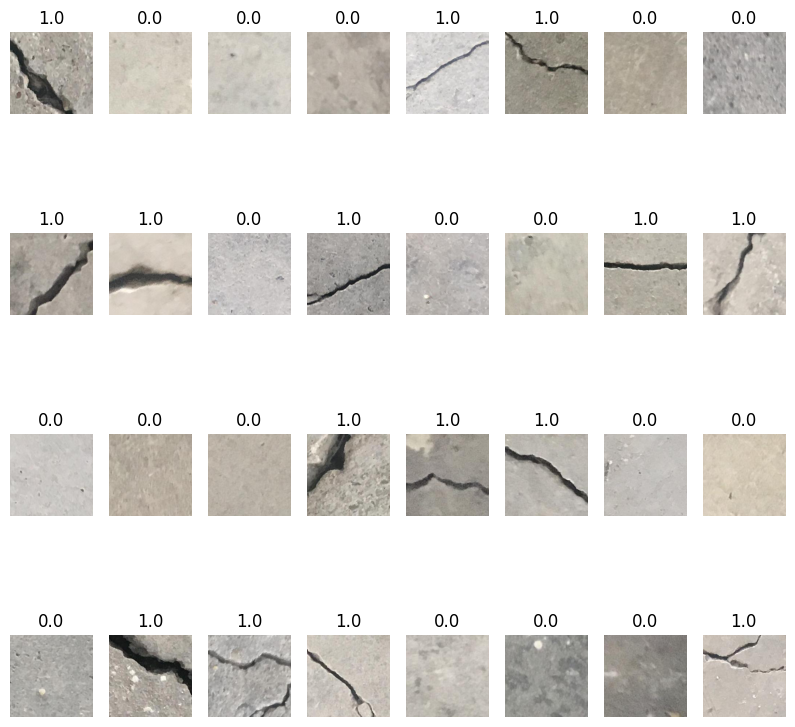

In [22]:
# Visualize the images and labels
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

**Define a custom CNN architecture for classification**

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import plot_model

In [25]:
# Defining the deep - lerning Architecture
inputs = Input(shape = (224, 224, 3))

x = BatchNormalization()(inputs)
x = Conv2D(filters = 16, kernel_size=(3,3), padding = 'same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = Dropout(0.2)(x) 

x = BatchNormalization()(x)
x = Conv2D(filters = 32, kernel_size=(3,3), padding = 'same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(16, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)

basic_crack_model = tf.keras.Model(inputs=inputs, outputs=outputs)
basic_crack_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 16)     64    

In [26]:
from tensorflow.keras.optimizers import RMSprop

In [27]:
#Compiling the model:
basic_crack_model.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [28]:
# Introducing some model call backs
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = 'basic_crack_model.h5'
callback_list = [ModelCheckpoint(filepath, save_best_only=True), EarlyStopping(monitor='val_loss',patience=3)]


*Fitting the model* 

In [29]:
basic_history = basic_crack_model.fit(train_ds, epochs = 25, validation_data=val_ds, shuffle=True, callbacks = callback_list)

Epoch 1/25
800/800 [==============================] - 101s 109ms/step - loss: 0.1416 - accuracy: 0.9536 - val_loss: 0.0617 - val_accuracy: 0.9869
Epoch 2/25
800/800 [==============================] - 92s 114ms/step - loss: 0.0614 - accuracy: 0.9835 - val_loss: 0.0372 - val_accuracy: 0.9905
Epoch 3/25
800/800 [==============================] - 97s 121ms/step - loss: 0.0508 - accuracy: 0.9867 - val_loss: 0.0843 - val_accuracy: 0.9817
Epoch 4/25
800/800 [==============================] - 101s 127ms/step - loss: 0.0418 - accuracy: 0.9881 - val_loss: 0.0329 - val_accuracy: 0.9917
Epoch 5/25
800/800 [==============================] - 83s 103ms/step - loss: 0.0423 - accuracy: 0.9899 - val_loss: 0.0354 - val_accuracy: 0.9895
Epoch 6/25
800/800 [==============================] - 85s 106ms/step - loss: 0.0370 - accuracy: 0.9900 - val_loss: 0.0610 - val_accuracy: 0.9902
Epoch 7/25
800/800 [==============================] - 82s 102ms/step - loss: 0.0353 - accuracy: 0.9902 - val_loss: 0.1206 - val_

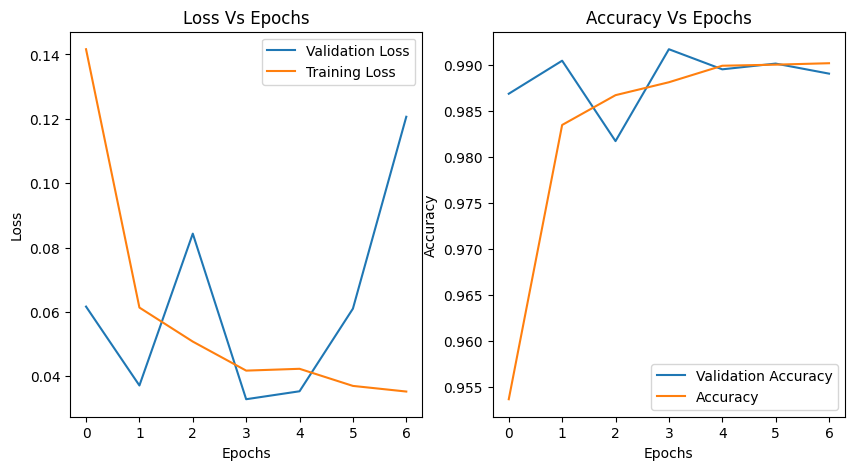

In [30]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
data = pd.DataFrame(basic_history.history)
data.head()
(a,b) = data.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), data['val_loss'], label = "Validation Loss")
plt.plot(range(a), data['loss'], label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), data['val_accuracy'], label = "Validation Accuracy")
plt.plot(range(a), data['accuracy'], label = "Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

*Creating a similar plot using plotly.express*

In [31]:
import plotly.express as px

In [32]:
fig = px.line(
    basic_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

#Results

*The model has been saved to google colab and we will load it from there.*

**Visualizing asome test and predicted Labels**

In [1]:
#Loading the pre-trained model from keras:
from keras.models import load_model 

In [2]:
model_path = '/content/drive/MyDrive/Trained Model Concrecte Crack Classification/basic_crack_model (1).h5' 

In [3]:
model = load_model(model_path)

In [23]:
images, lables = next(test_ds) 

In [24]:
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32,)


In [25]:
#Let us run a prediction of the trained model on the test dataset:
predictions = model.predict(images) 

250/250 [==============================] - 186s 741ms/step


In [26]:
print(predictions.shape)

(8000, 1)


In [31]:
print(predictions[:5])

[[7.4241012e-05]
 [9.9963939e-01]
 [4.1865837e-03]
 [1.2143401e-03]
 [8.6341740e-04]]


**The predictions are nothing but probabilities, we need to comvert them to 0 and 1 based on some threshold**

In [40]:
# Let us define a threshold of 0.5

threshold = (predictions < 0.5).astype('int')
pred = np.squeeze(threshold)
print(pred[0:32])

[1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0]


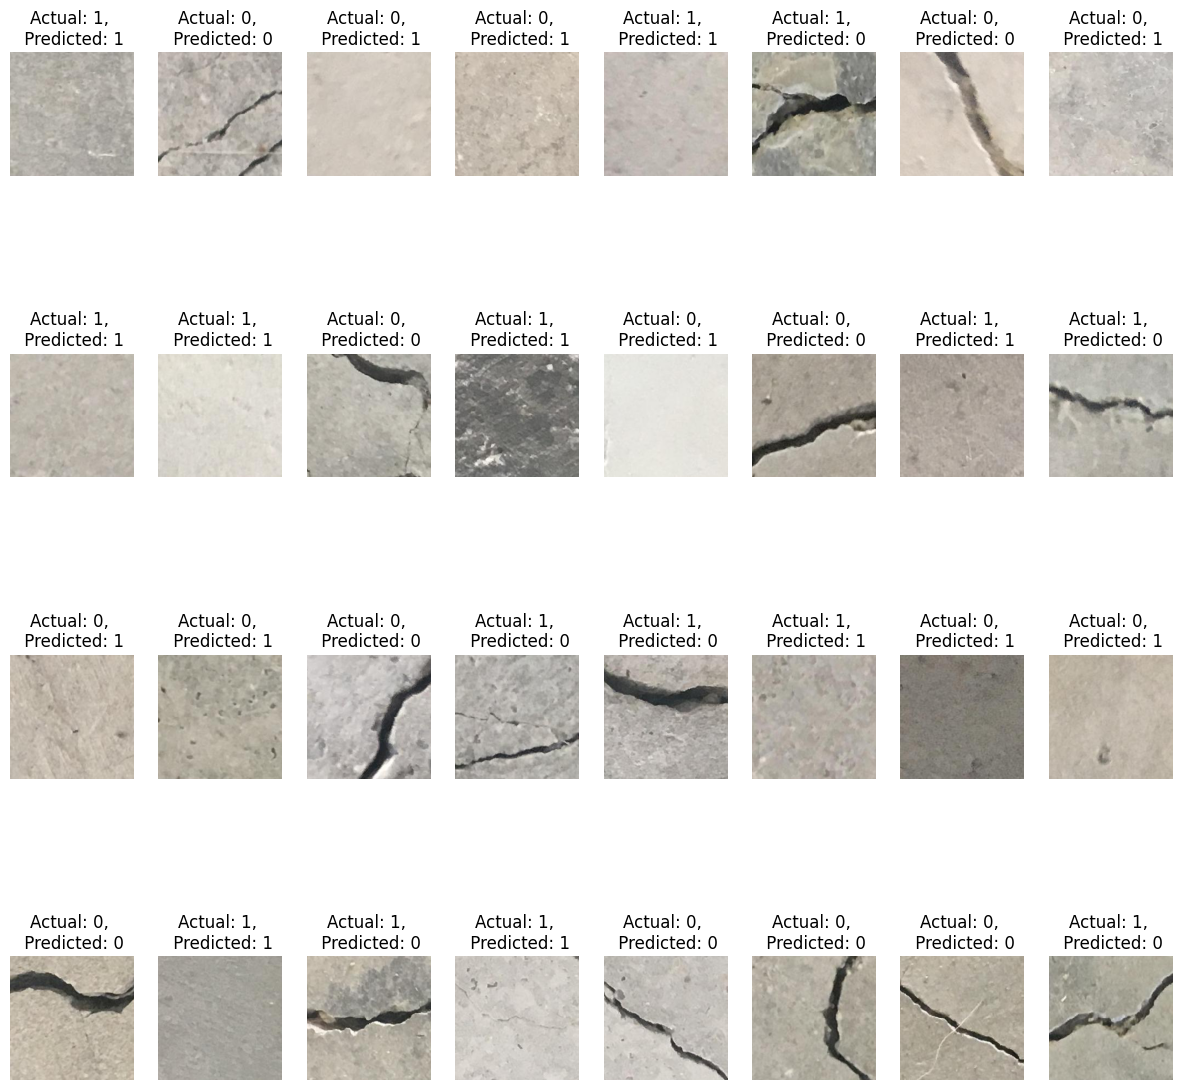

In [39]:
#Let us plot the images, labels and the respective predictions made by the model for the first batch(32 images) in the test dataset:
# Visualize the images and labels
plt.figure(figsize=(15, 15))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i])
    plt.title(f'Actual: {labels[i].astype(int)}, \n Predicted: {pred[i]}')
    plt.axis('off')
plt.show()

**Creating a function for model Evaluation**

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [47]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype('int'))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.03006
Test Accuracy: 99.46%
250/250 [==============================] - 143s 571ms/step


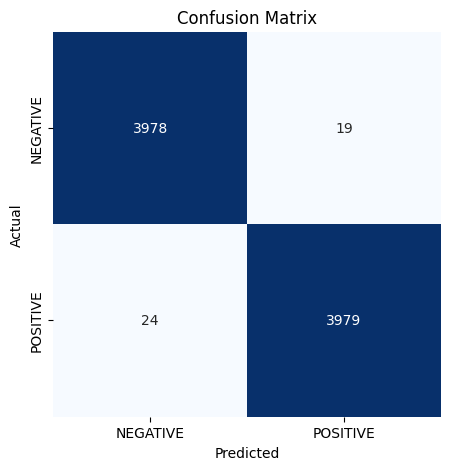

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      0.99      3997
    POSITIVE       1.00      0.99      0.99      4003

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



In [48]:
evaluate_model(model, test_ds)

#Observation-

**Out of the False predictions, the most important ones for this particular case is FalseNegative. It means that there is actually a crack in a building, but the model is predicting No Crack. This can lead to detrimental effects.** 